In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model, plot_rdm
import multitask.models.task_switching.utils as utils
import multitask.models.task_switching.hooks as hooks

from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')

In [3]:
path_data = os.path.join('..', '..', 'data')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
path_figure_activations = os.path.join('svg', 'figureS17_rdm_task_switching_activations.svg')
path_figure_rdm_pearson = os.path.join('svg', 'figureS17_rdm_task_switching_pearson.svg')
path_figure_rdm_cosine = os.path.join('svg', 'figureS17_rdm_task_switching_cosine.svg')
path_figure_rdm_spearman = os.path.join('svg', 'figureS17_rdm_task_switching_spearman.svg')

In [5]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
# tasks_names = ['parity', 'value', 'prime', 'fibonacci', 'multiples3']
idxs_contexts = list(range(len(num_hidden)))
num_tasks = len(tasks_names)

In [6]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_18_47)


In [7]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [8]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [9]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [10]:
from scipy.stats import spearmanr

num_classes = 10


def get_mean_activations(activations, names_tasks, num_hidden, list_numbers):
    """
    Calculates the mean_activation matrix per layer.

    Args:
        activations (dict): Dictionary of np.ndarray containing the matrix|
            of activations (N_test x N_hidden_units).
        names_tasks (list): Names of tasks.
        num_hidden (list): Number of hidden units per layer.
        list_numbers (list): List of numbers of test set (N_test, ).

    Returns:
        dict: Mean of activations per layer.
    """
    mean_activations = {}
    for name_task in names_tasks:
        mean_activations[name_task] = {}
        for i_layer, num_units in enumerate(num_hidden, 1):
            layer_name = f"layer{i_layer}"
            mean_activations[name_task][layer_name] = \
                np.zeros((num_classes, num_units))
            for number in range(num_classes):
                idxs_activations = list_numbers == number
                activations_number = activations[name_task][layer_name][
                    idxs_activations, :
                ]
                mean_activations[name_task][layer_name][number, :] = np.mean(
                    activations_number, axis=0
                )

    return mean_activations


def calculate_rdm_spearman(activations, test_tasks, num_hidden, list_numbers):
    """
    Calculates the Representational Dissimilarity Matrix (RDM) per layer.

    Args:
        activations_tasks (list): List of dictionaries of activations per task.
        test_tasks (dict): Dictionary of test tasks.
        num_hidden (list): Number of hidden units per layer.
        list_numbers (list): List of numbers of test set (N_test, ).

    Returns:
        dict: Dictionary of RDMs per layer.
    """
    names_tasks = list(test_tasks.keys())
    mean_activations = get_mean_activations(
        activations, names_tasks, num_hidden, list_numbers
    )
    rdm_dict = {}

    for i_layer, _ in enumerate(num_hidden, 1):
        layer_name = f"layer{i_layer}"

        mean_activations_layer = None
        for name_task in names_tasks:
            if mean_activations_layer is None:
                mean_activations_layer = \
                    mean_activations[name_task][layer_name]
            else:
                mean_activations_layer = np.vstack(
                    (mean_activations_layer,
                     mean_activations[name_task][layer_name])
                )

        correlation_dm, _ = spearmanr(mean_activations_layer, axis=1)
        rdm_dict[i_layer] = (1 - correlation_dm) / 2

    return rdm_dict

## Plot All RDMs

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

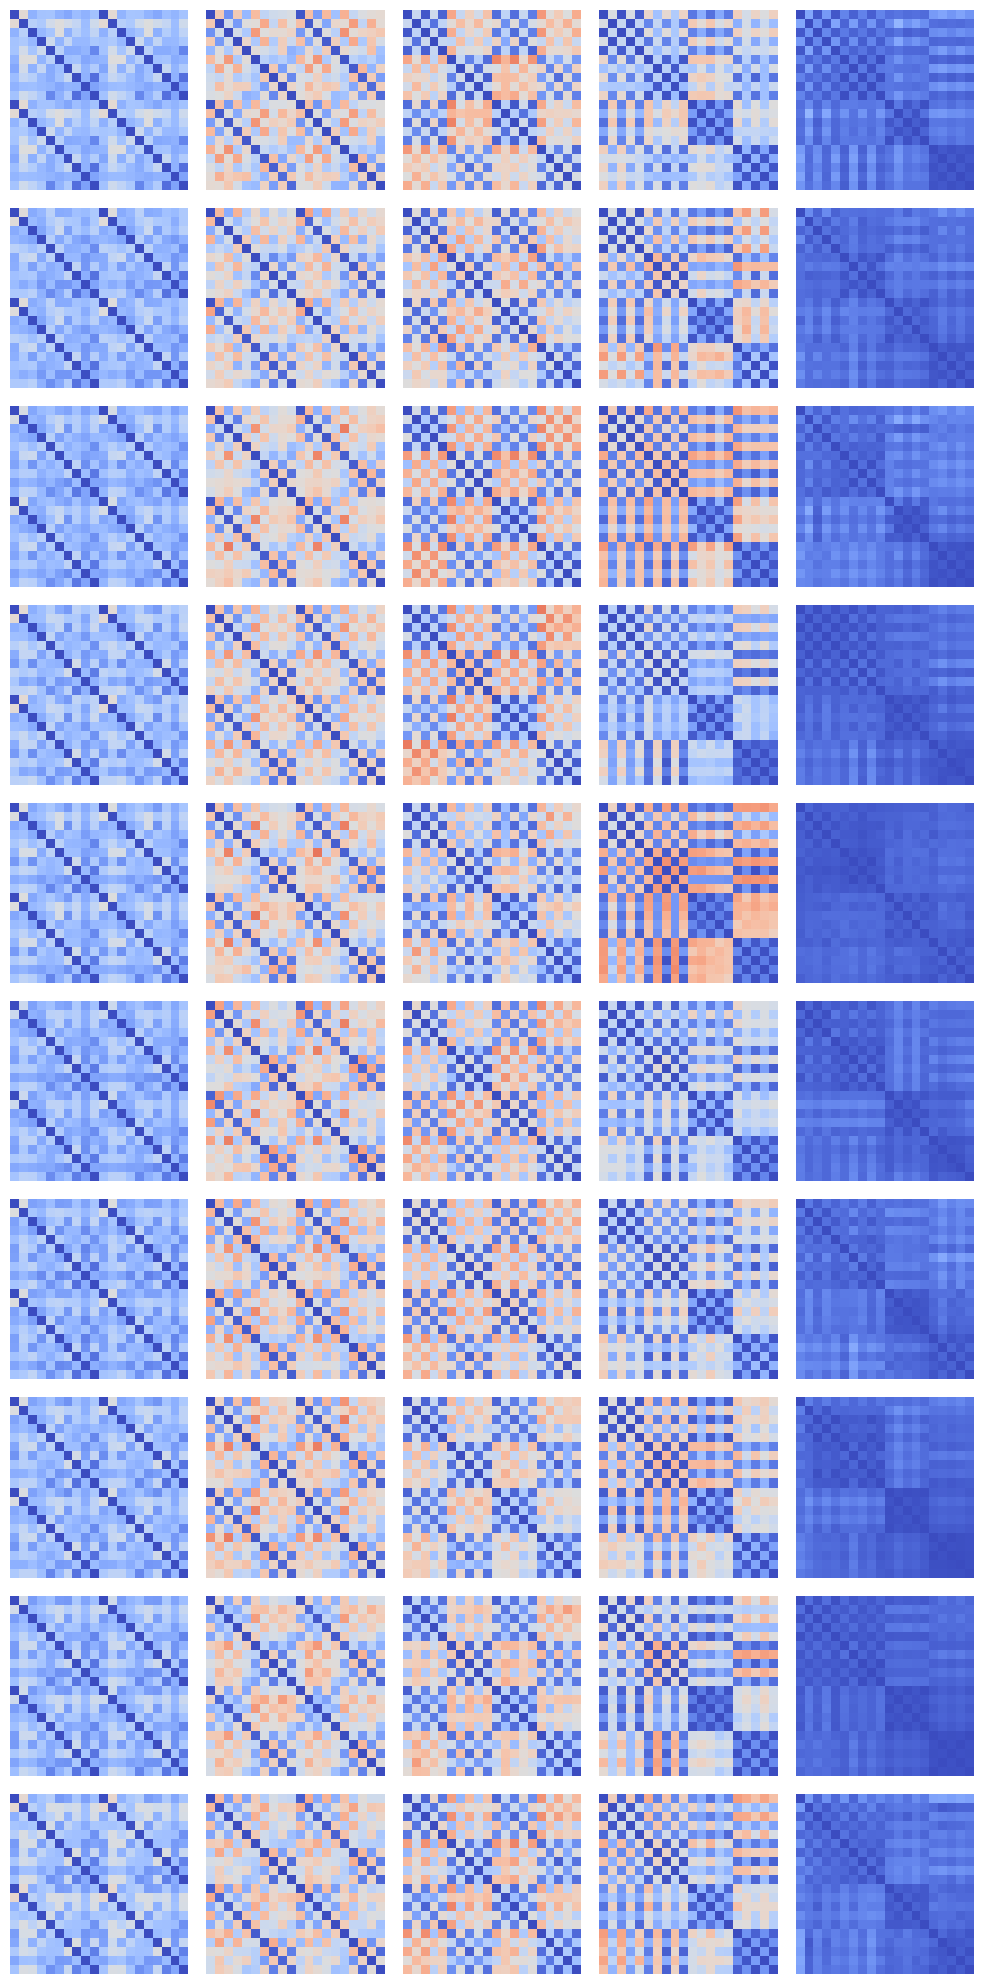

In [11]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
list_rdm = []

fig, ax = plt.subplots(num_runs, num_layers, figsize=(2 * num_layers, 2 * num_runs))

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    rdm_dict = calculate_rdm_spearman(activations,
                                      task_switching_tasks,
                                      num_hidden,
                                      numbers)
    list_rdm.append(rdm_dict)

    plot_rdm(ax[i_seed], rdm_dict, num_hidden, idxs_contexts, cmap='coolwarm', vmin=0, vmax=1)

fig.tight_layout()
plt.show()

## Average RDM

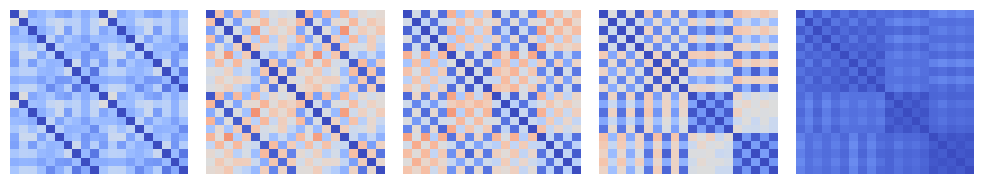

In [12]:
mean_rdm = {}

for layer in range(num_layers):
    mean_rdm[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_rdm:
        mean_rdm[layer+1] += rdm[layer+1]
    mean_rdm[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm, num_hidden, idxs_contexts, cmap='coolwarm', vmin=0, vmax=1)
fig.tight_layout()

plt.show()

In [13]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [14]:
mean_activations = get_mean_activations(
        activations, task_switching_tasks, num_hidden, numbers
)

In [15]:
mean_activations_parity = mean_activations['parity']['layer5']
mean_activations_value = mean_activations['value']['layer5']

In [16]:
parity_0 = mean_activations_parity[0, :]
value_2 = mean_activations_value[4, :]
value_6 = mean_activations_value[6, :]

pearson_parity_0_value_2 = np.corrcoef(parity_0, value_2)[0, 1]
spearman_parity_0_value_2, _ = spearmanr(parity_0, value_2)
cosine_parity_0_value_2 = cosine_similarity(parity_0.reshape(1, -1), value_2.reshape(1, -1)).item()

pearson_parity_0_value_6 = np.corrcoef(parity_0, value_6)[0, 1]
spearman_parity_0_value_6, _ = spearmanr(parity_0, value_6)
cosine_parity_0_value_6 = cosine_similarity(parity_0.reshape(1, -1), value_6.reshape(1, -1)).item()

In [ ]:
plt.style.use('../style/plots.mplstyle')

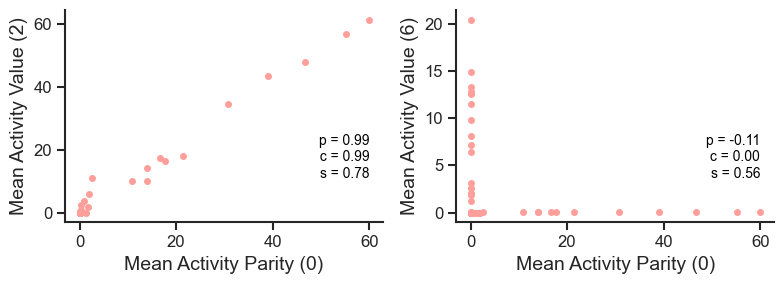

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].plot(parity_0, value_2, '.', markersize=8, color='r')
ax[0].set_xlabel('Mean Activity Parity (0)', fontsize=14)
ax[0].set_ylabel('Mean Activity Value (2)', fontsize=14)

ax[1].plot(parity_0, value_6, '.', markersize=8, color='r')
ax[1].set_xlabel('Mean Activity Parity (0)', fontsize=14)
ax[1].set_ylabel('Mean Activity Value (6)', fontsize=14)

fig.tight_layout()


text0 = (f"p = {pearson_parity_0_value_2:.2f}\n "
         f"c = {cosine_parity_0_value_2:.2f}\n"
         f"s = {spearman_parity_0_value_2:.2f}\n")


text1 = (f"p = {pearson_parity_0_value_6:.2f}\n"
         f"c = {cosine_parity_0_value_6:.2f}\n"
         f"s = {spearman_parity_0_value_6:.2f}\n")

ax[0].text(60, 15, text0, ha='right', va='center', color='black', fontsize=10)
ax[1].text(60, 5, text1, ha='right', va='center', color='black', fontsize=10)

fig.savefig(path_figure_activations)
fig.tight_layout()

plt.show()

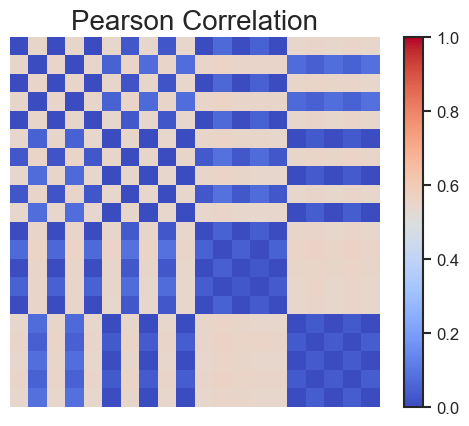

In [18]:
pearson_correlation = np.corrcoef(mean_activations_parity, mean_activations_value, rowvar=True)

fig = plt.figure()
plt.imshow((1 - pearson_correlation) / 2, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Pearson Correlation', fontsize=20)
plt.axis('off')
plt.colorbar()

fig.savefig(path_figure_rdm_pearson)

plt.show()

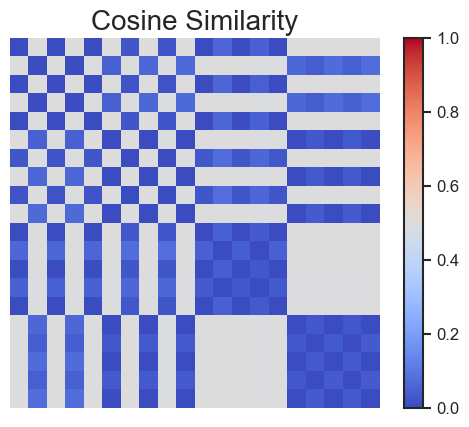

In [19]:
activations_stack = np.vstack((mean_activations_parity, mean_activations_value))
cosine_similarity_matrix = cosine_similarity(activations_stack)

fig = plt.figure()

plt.imshow((1 - cosine_similarity_matrix) / 2, vmin=0, vmax=1, cmap='coolwarm')
plt.title('Cosine Similarity', fontsize=20)

plt.colorbar()
plt.axis('off')

fig.savefig(path_figure_rdm_cosine)

plt.show()

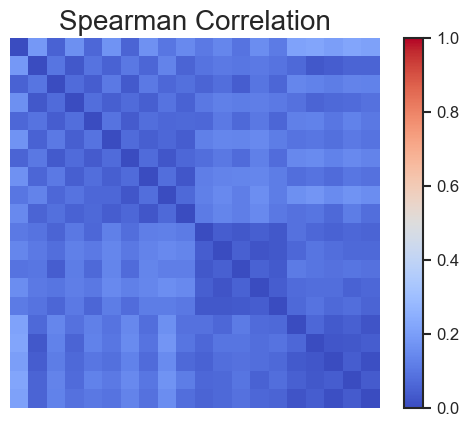

In [20]:
spearman, _ = spearmanr(mean_activations_parity, mean_activations_value, axis=1)

fig = plt.figure()

plt.imshow((1 - spearman) / 2, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Spearman Correlation', fontsize=20)
plt.axis('off')
plt.colorbar()

fig.savefig(path_figure_rdm_spearman)

plt.show()